In [1]:
#导入MindSpore模块和辅助模块：

import os
import csv
import numpy as np

import mindspore as ms
from mindspore import nn, dataset 
from mindspore.train import LossMonitor

ms.set_context(mode=ms.GRAPH_MODE, device_target="CPU")

In [2]:
#读取Iris数据集`iris.data`，并作检查
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[0:5]); print(data[50:55]); print(data[100:105]) # 打印部分数据

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'], ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'], ['4.7', '3.2', '1.3', '0.2', 'Iris-setosa'], ['4.6', '3.1', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.6', '1.4', '0.2', 'Iris-setosa']]
[['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor']]
[['6.3', '3.3', '6.0', '2.5', 'Iris-virginica'], ['5.8', '2.7', '5.1', '1.9', 'Iris-virginica'], ['7.1', '3.0', '5.9', '2.1', 'Iris-virginica'], ['6.3', '2.9', '5.6', '1.8', 'Iris-virginica'], ['6.5', '3.0', '5.8', '2.2', 'Iris-virginica']]


In [3]:
#数据集的3类样本共150条，将样本的4个属性作为自变量$X$，将样本的3个类别映射为{0, 1, 2}，作为因变量$Y$。
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
X = np.array([[float(x) for x in s[:-1]] for s in data[:150]], np.float32)
print(X[0])
Y = np.array([label_map[s[-1]] for s in data[:150]], np.int32)
print(Y[0])

[5.1 3.5 1.4 0.2]
0


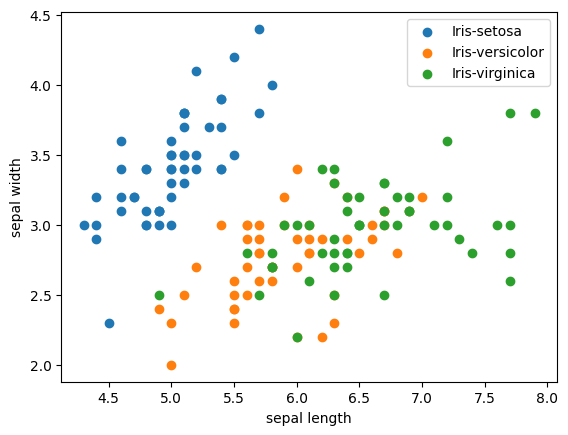

In [4]:
#取样本的前两个属性进行2维可视化，可以看到在前两个属性上其中一类和余下两类是线性可分的，而余下两类之间线性不可分。
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], label='Iris-versicolor')
plt.scatter(X[100:, 0], X[100:, 1], label='Iris-virginica')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [5]:
#将数据集按8:2划分为训练集和验证集
train_idx = np.random.choice(150, 120, replace=False)
print(train_idx)
test_idx = np.array(list(set(range(150)) - set(train_idx)))
print(test_idx)
X_train, Y_train = X[train_idx], Y[train_idx]
print(X_train, Y_train)
X_test, Y_test = X[test_idx], Y[test_idx]
print(X_test, Y_test)

[ 70 126 125  27 106 101 131  82  13  26   3 114 140  31 116  19  90  15
 118 113  75 142 139 109 103  65 102  37  57  64 137 128 134  63  42  84
  45  28 132  72 143  98  73  89  12  60 121  36  55 127 130  74  69  41
 124  78  86  10   1  71 120 129  85  21  94  68  11  83 119 133 138  95
  59   2  30   8  81 141  40  34  14  91   5 135  92  99  25  22  54 122
 144 117  29  61 110  39 148  32  49  51  96  52 104  48  79  67 147 105
   4  20  23 149  50  88  62  16  18   6  56 100]
[  0   7 136   9  17 145 146  24  33  35  38  43  44  46  47  53  58  66
  76  77  80  87  93  97 107 108 111 112 115 123]
[[5.9 3.2 4.8 1.8]
 [6.2 2.8 4.8 1.8]
 [7.2 3.2 6.  1.8]
 [5.2 3.5 1.5 0.2]
 [4.9 2.5 4.5 1.7]
 [5.8 2.7 5.1 1.9]
 [7.9 3.8 6.4 2. ]
 [5.8 2.7 3.9 1.2]
 [4.3 3.  1.1 0.1]
 [5.  3.4 1.6 0.4]
 [4.6 3.1 1.5 0.2]
 [5.8 2.8 5.1 2.4]
 [6.7 3.1 5.6 2.4]
 [5.4 3.4 1.5 0.4]
 [6.5 3.  5.5 1.8]
 [5.1 3.8 1.5 0.3]
 [5.5 2.6 4.4 1.2]
 [5.7 4.4 1.5 0.4]
 [7.7 2.6 6.9 2.3]
 [5.7 2.5 5.  2. ]
 [6.6 3. 

In [6]:
#使用MindSpore`GeneratorDataset`接口将numpy.ndarray类型的数据转换为Dataset
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=120).batch(32, drop_remainder=True)

XY_test = list(zip(X_test, Y_test))
ds_test = dataset.GeneratorDataset(XY_test, ['x', 'y'])
ds_test = ds_test.batch(30)

In [7]:
net = nn.Dense(4, 3)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.Momentum(net.trainable_params(), learning_rate=0.05, momentum=0.9)


In [8]:
model = ms.train.Model(net, loss, opt, metrics={'acc', 'loss'})
model.train(25, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)
metrics = model.eval(ds_test)
print(metrics)

epoch: 1 step: 3, loss is 1.090165376663208
epoch: 2 step: 3, loss is 0.8090458512306213
epoch: 3 step: 3, loss is 0.8318896293640137
epoch: 4 step: 3, loss is 0.5345371961593628
epoch: 5 step: 3, loss is 0.44281601905822754
epoch: 6 step: 3, loss is 0.5257410407066345
epoch: 7 step: 3, loss is 0.4006847143173218
epoch: 8 step: 3, loss is 0.4820346236228943
epoch: 9 step: 3, loss is 0.40108203887939453
epoch: 10 step: 3, loss is 0.5597110986709595
epoch: 11 step: 3, loss is 0.41222938895225525
epoch: 12 step: 3, loss is 0.2739887833595276
epoch: 13 step: 3, loss is 0.5264859795570374
epoch: 14 step: 3, loss is 0.3064676821231842
epoch: 15 step: 3, loss is 0.3868437707424164
epoch: 16 step: 3, loss is 0.5328673124313354
epoch: 17 step: 3, loss is 0.4225291609764099
epoch: 18 step: 3, loss is 0.3358394205570221
epoch: 19 step: 3, loss is 0.2020341157913208
epoch: 20 step: 3, loss is 0.16700991988182068
epoch: 21 step: 3, loss is 0.22951669991016388
epoch: 22 step: 3, loss is 0.1666093915